# Eikonal solver with Physics-Informed Neural Networks (PINNs) - Velocity gradient

In this lab of the **ErSE 222 - Machine Learning in Geoscience** course, we will expand the previous notebook to the case of vertical velocity gradient.

A nice property of PINNs is that the code remains almost unchanged from the case of constant velocity. The main difference here is that we need to choose a constant velocity $V_0$ to compute the analytical solution $T_0$: our choice is to take the velocity at the source location as $V_0$. Moreover, when evaluating the PDE loss term we will use the velocity gradient in this case.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import skfmm

from torch.utils.data import TensorDataset, DataLoader
from utils import *
from model import *
from train import *

In [2]:
set_seed(10)
device = set_device()

No GPU available!


### Parameters

In [3]:
# Network
act = 'ELU'
lay = 'linear' # 'adaptive'
unit = 30 # number of units for each layer
hidden = 10 # number of hidden layers

# Optimizer
opttype = 'adam'
lr = 1e-4
epochs = 1000
perc = 0.25 # 0.25
randompoints = True
batch_size = 256

# Weights
lambda_pde, lambda_init = 1., 10.

### Geometry and initial traveltime

In [4]:
# Model grid (km)
ox, dx, nx = 0., 10./1000., 101 
oz, dz, nz = 0., 10./1000., 201 

# Velocity model (km/s)
v0 = 750./1000.
k = 0.5
z = np.arange(nz)*dz + oz
vel = np.outer((v0 + k * z), np.ones(nx)).T

# Source (km)
xs, zs = 500./1000., 500./1000.

In [5]:
# Computational domain
x, z, X, Z = eikonal_grid(ox, dx, nx, oz, dz, nz)
    
# Analytical solution
isource = (X == xs) & (Z == zs)
vsource = vel.ravel()[isource][0]
t0, t0_dx, t0_dz = eikonal_constant(ox, dx, nx, oz, dz, nz, xs, zs, vsource)
tana = eikonal_gradient(ox, dx, nx, oz, dz, nz, xs, zs, v0, k)

# Eikonal solution
teik = eikonal_fmm(ox, dx, nx, oz, dz, nz, xs, zs, vel)

# Factorized eikonal solution: t= tau * t0
tauana = tana / t0
tauana[np.isnan(tauana)] = 1.

/Users/ravasim/Desktop/KAUST/Teaching/MLgeoscience/CourseNotes/labs/notebooks/EikonalPINN/utils.py:55: RuntimeWarning: invalid value encountered in true_divide
  tana_dx = (X - xs) / (dana.ravel() * v)
/Users/ravasim/Desktop/KAUST/Teaching/MLgeoscience/CourseNotes/labs/notebooks/EikonalPINN/utils.py:56: RuntimeWarning: invalid value encountered in true_divide
  tana_dz = (Z - zs) / (dana.ravel() * v)
<ipython-input-5-1a2fedcd683a>:14: RuntimeWarning: invalid value encountered in true_divide
  tauana = tana / t0


<ipython-input-6-803b75e26f23>:7: UserWarning: The following kwargs were not used by contour: 'label'
  axs[1].contour(tana.T, extent=(x[0], x[-1], z[0], z[-1]), colors='k', label='Analytical')
<ipython-input-6-803b75e26f23>:8: UserWarning: The following kwargs were not used by contour: 'label'
  axs[1].contour(teik.T, extent=(x[0], x[-1], z[0], z[-1]), colors='r', label='Numerical')
No handles with labels found to put in legend.


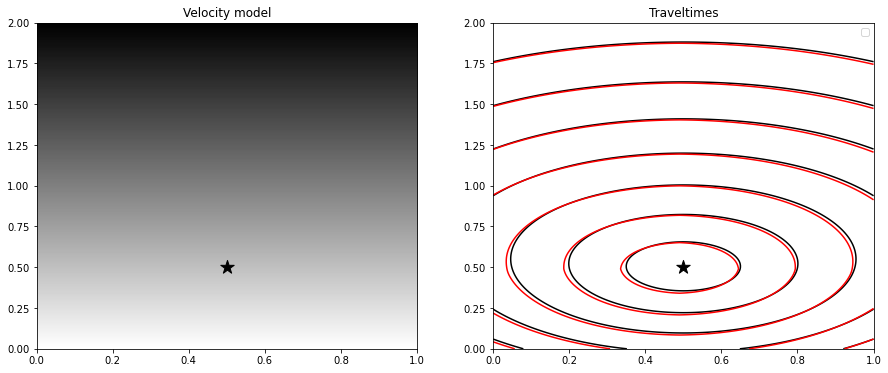

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].imshow(vel.T, extent=(x[0], x[-1], z[0], z[-1]), cmap='gray_r', origin='lower')
axs[0].scatter(xs, zs, s=200, marker='*', color='k')
axs[0].set_title('Velocity model')
axs[0].axis('tight')

axs[1].contour(tana.T, extent=(x[0], x[-1], z[0], z[-1]), colors='k', label='Analytical')
axs[1].contour(teik.T, extent=(x[0], x[-1], z[0], z[-1]), colors='r', label='Numerical')
axs[1].scatter(xs, zs, s=200, marker='*', color='k')
axs[1].set_title('Traveltimes')
axs[1].legend()
axs[1].axis('tight');

### Training data and network

In [7]:
# Remove source from grid of points to be used in training
X_nosrc, Z_nosrc, v_nosrc, t0_nosrc, t0_dx_nosrc, t0_dz_nosrc = \
    remove_source(X, Z, xs, zs, vel, t0, t0_dx, t0_dz)

In [8]:
# Create evaluation grid
grid_loader = create_gridloader(X, Z, device)

In [9]:
# Define and initialize network
model = Network(2, 1, [unit]*hidden, act=act, lay=lay)
model.to(device)
#model.apply(model.init_weights)
print(model)

Network(
  (model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=30, bias=True)
      (1): ELU(alpha=1.0)
    )
    (1): Sequential(
      (0): Linear(in_features=30, out_features=30, bias=True)
      (1): ELU(alpha=1.0)
    )
    (2): Sequential(
      (0): Linear(in_features=30, out_features=30, bias=True)
      (1): ELU(alpha=1.0)
    )
    (3): Sequential(
      (0): Linear(in_features=30, out_features=30, bias=True)
      (1): ELU(alpha=1.0)
    )
    (4): Sequential(
      (0): Linear(in_features=30, out_features=30, bias=True)
      (1): ELU(alpha=1.0)
    )
    (5): Sequential(
      (0): Linear(in_features=30, out_features=30, bias=True)
      (1): ELU(alpha=1.0)
    )
    (6): Sequential(
      (0): Linear(in_features=30, out_features=30, bias=True)
      (1): ELU(alpha=1.0)
    )
    (7): Sequential(
      (0): Linear(in_features=30, out_features=30, bias=True)
      (1): ELU(alpha=1.0)
    )
    (8): Sequential(
      (0): Linear(in_feature

<ipython-input-10-7bcacac579a5>:12: UserWarning: The following kwargs were not used by contour: 'label'
  axs[1].contour(tana.T, extent=(x[0], x[-1], z[0], z[-1]), colors='k', label='Analytical')
<ipython-input-10-7bcacac579a5>:13: UserWarning: The following kwargs were not used by contour: 'label'
  axs[1].contour((tau_est_init.detach().cpu().numpy().reshape(nx, nz) * t0).T,
No handles with labels found to put in legend.


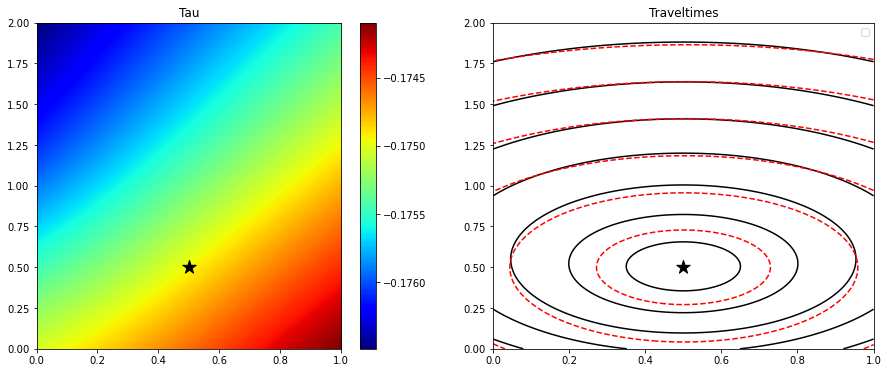

In [10]:
# Compute traveltime with randomly initialized network 
tau_est_init = evaluate(model, grid_loader)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
im = axs[0].imshow(tau_est_init.detach().cpu().numpy().reshape(nx, nz).T, 
                   extent=(x[0], x[-1], z[0], z[-1]), cmap='jet', origin='lower')
axs[0].scatter(xs, zs, s=200, marker='*', color='k')
axs[0].set_title('Tau')
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])

axs[1].contour(tana.T, extent=(x[0], x[-1], z[0], z[-1]), colors='k', label='Analytical')
axs[1].contour((tau_est_init.detach().cpu().numpy().reshape(nx, nz) * t0).T, 
               extent=(x[0], x[-1], z[0], z[-1]), colors='r', label='Estimated')
axs[1].scatter(xs, zs, s=200, marker='*', color='k')
axs[1].set_title('Traveltimes')
axs[1].legend()
axs[1].axis('tight');

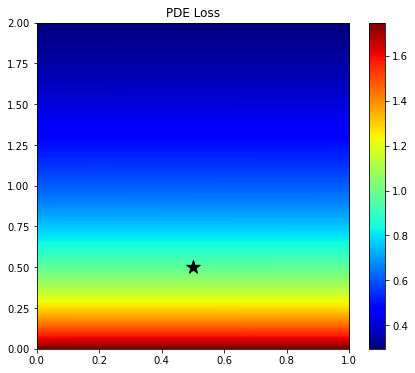

In [11]:
# Compute PDE loss
pde_loader, _ = create_dataloader(X, Z, xs, zs, vel.ravel(), t0.ravel(), t0_dx.ravel(), t0_dz.ravel(), 
                                  perc=1., shuffle=False)

pde, _ = evaluate_pde(model, pde_loader)

plt.figure(figsize=(7, 6))
im = plt.imshow(np.abs(pde.detach().cpu().numpy().reshape(nx, nz).T),
                extent=(x[0], x[-1], z[0], z[-1]), cmap='jet', origin='lower')
plt.scatter(xs, zs, s=200, marker='*', color='k')
plt.title('PDE Loss')
plt.axis('tight')
plt.colorbar(im);

### Train and compute traveltime in entire grid

Number of points used per epoch:5075
Epoch 0, Loss 13.9093728
Recreate dataloader...
Number of points used per epoch:5075
Epoch 100, Loss 0.0017168
Epoch 200, Loss 0.0001605
Epoch 300, Loss 0.0000215
Epoch 400, Loss 0.0000049
Epoch 500, Loss 0.0000078
Epoch 600, Loss 0.0000031
Epoch 700, Loss 0.0000059
Epoch 800, Loss 0.0000025
Epoch 900, Loss 0.0000020


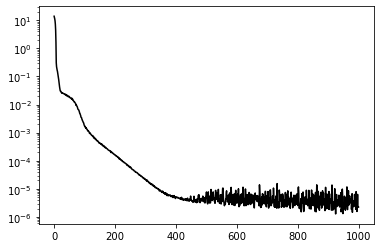

In [12]:
# Optimizer
if opttype == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-5)
elif opttype == 'lbfgs':
    optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn="strong_wolfe")

# Training
loss_history, loss_pde_history, loss_ic_history, tau_history = \
    training_loop(X_nosrc, Z_nosrc, xs, zs, v_nosrc, t0_nosrc, t0_dx_nosrc, t0_dz_nosrc,
                  model, optimizer, epochs, Xgrid=X, Zgrid=Z,
                  randompoints=randompoints, batch_size=batch_size, perc=perc, 
                  lossweights=(lambda_pde, lambda_init), device=device)

plt.figure()
plt.semilogy(loss_history, 'k');

<ipython-input-13-770bce855755>:18: UserWarning: The following kwargs were not used by contour: 'label'
  im = axs[2].contour(tana.T, extent=(x[0], x[-1], z[0], z[-1]), colors='k', label='Analytical')
<ipython-input-13-770bce855755>:19: UserWarning: The following kwargs were not used by contour: 'label'
  axs[2].contour((tau_est.detach().cpu().numpy().reshape(nx, nz) * t0).T,
No handles with labels found to put in legend.


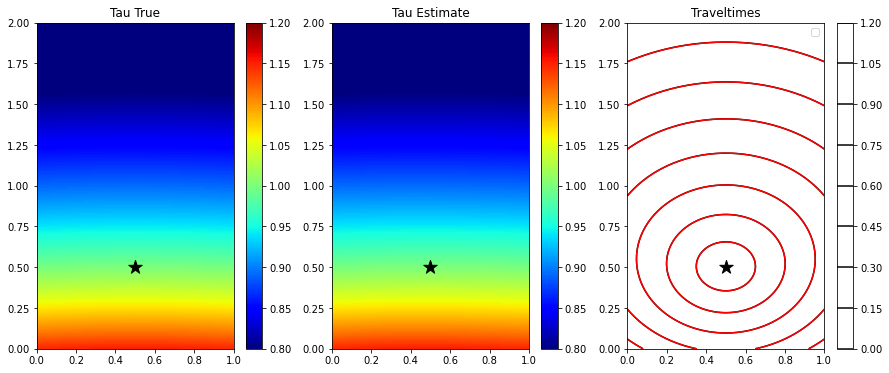

In [13]:
# Compute traveltime with trained network 
tau_est = evaluate(model, grid_loader)

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
im = axs[0].imshow(tauana.T, vmin=0.8, vmax=1.2,
                   extent=(x[0], x[-1], z[0], z[-1]), cmap='jet', origin='lower')
axs[0].scatter(xs, zs, s=200, marker='*', color='k')
axs[0].set_title('Tau True')
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(tau_est.detach().cpu().numpy().reshape(nx, nz).T, vmin=0.8, vmax=1.2,
                   extent=(x[0], x[-1], z[0], z[-1]), cmap='jet', origin='lower')
axs[1].scatter(xs, zs, s=200, marker='*', color='k')
axs[1].set_title('Tau Estimate')
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1])

im = axs[2].contour(tana.T, extent=(x[0], x[-1], z[0], z[-1]), colors='k', label='Analytical')
axs[2].contour((tau_est.detach().cpu().numpy().reshape(nx, nz) * t0).T, 
               extent=(x[0], x[-1], z[0], z[-1]), colors='r', label='Estimated')
#axs[2].contour(t0.T, 
#               extent=(x[0], x[-1], z[0], z[-1]), colors='b', label='Initial')
axs[2].scatter(xs, zs, s=200, marker='*', color='k')
axs[2].set_title('Traveltimes')
axs[2].legend()
axs[2].axis('tight')
#im = axs[2].imshow(tana.T-(tau_est.detach().cpu().numpy().reshape(nx, nz) * t0).T, 
#                   vmin=-0.001, vmax=0.001,
#                   extent=(x[0], x[-1], z[0], z[-1]), cmap='jet', origin='lower')
#axs[2].scatter(xs, zs, s=200, marker='*', color='k')
#axs[2].set_title('Error')
#axs[2].axis('tight')
plt.colorbar(im, ax=axs[2]);

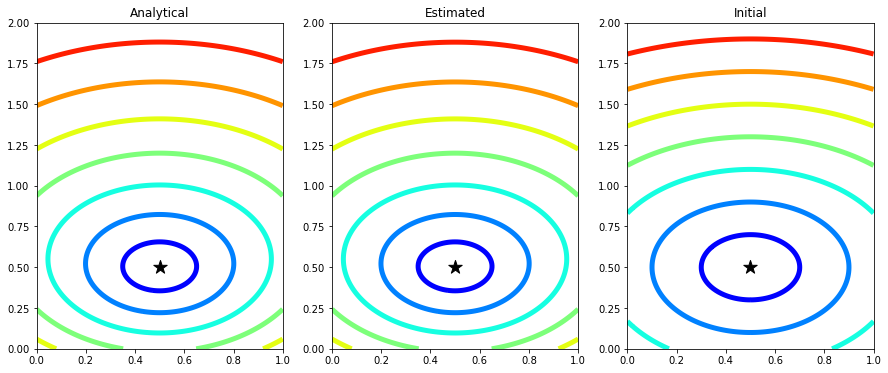

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].contour(tana.T, extent=(x[0], x[-1], z[0], z[-1]), cmap='jet', linewidths=5)
axs[0].scatter(xs, zs, s=200, marker='*', color='k')
axs[0].set_title('Analytical')
axs[0].axis('tight')
axs[1].contour((tau_est.detach().cpu().numpy().reshape(nx, nz) * t0).T, 
               extent=(x[0], x[-1], z[0], z[-1]), cmap='jet', linewidths=5)
axs[1].scatter(xs, zs, s=200, marker='*', color='k')
axs[1].set_title('Estimated')
axs[2].contour(t0.T, extent=(x[0], x[-1], z[0], z[-1]), cmap='jet', linewidths=5)
axs[2].scatter(xs, zs, s=200, marker='*', color='k')
axs[2].set_title('Initial')
axs[2].axis('tight');

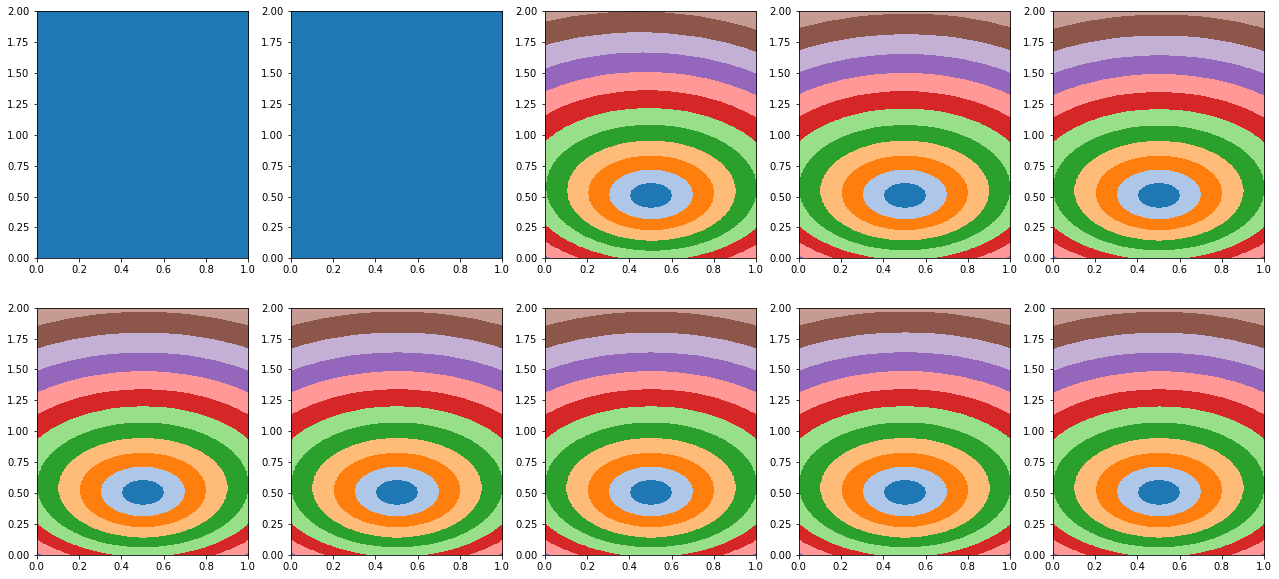

In [15]:
fig, axs = plt.subplots(2, len(tau_history)//2 , figsize=(len(tau_history)*2, 10))
axs = axs.ravel()

for ax, tau in zip(axs, tau_history):
    ax.imshow((tau.detach().cpu().numpy().reshape(nx, nz) * t0).T, 
              extent=(x[0], x[-1], z[0], z[-1]), cmap='tab20', origin='lower', vmin=0., vmax=2.)
    ax.axis('tight')

In [16]:
error = np.linalg.norm(tana.ravel()-(tau_est.detach().cpu().numpy().reshape(nx, nz) * t0).ravel())
print('Overall error', error)

Overall error 0.03220384504048704


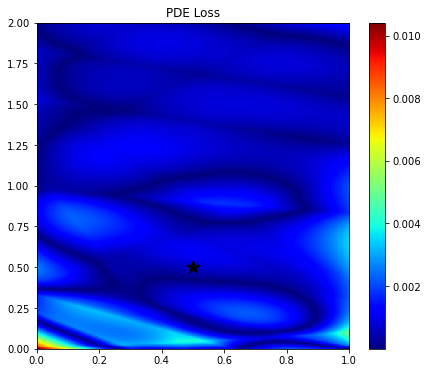

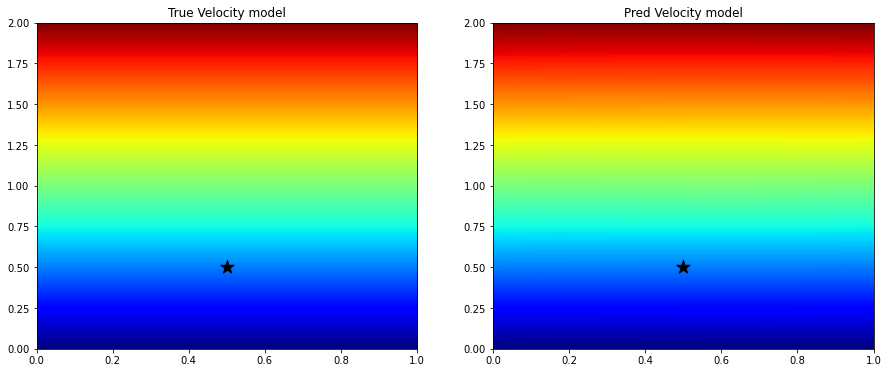

In [17]:
# Compute PDE loss
pde_loader, _ = create_dataloader(X, Z, xs, zs, vel.ravel(), t0.ravel(), t0_dx.ravel(), t0_dz.ravel(), 
                                  perc=1., shuffle=False)

pde, vpred = evaluate_pde(model, pde_loader)

plt.figure(figsize=(7, 6))
im = plt.imshow(np.abs(pde.detach().cpu().numpy().reshape(nx, nz).T),
                extent=(x[0], x[-1], z[0], z[-1]), cmap='jet', origin='lower')
plt.scatter(xs, zs, s=200, marker='*', color='k')
plt.title('PDE Loss')
plt.axis('tight')
plt.colorbar(im);

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].imshow(vel.T, extent=(x[0], x[-1], z[0], z[-1]), vmin=vel.min(), vmax=vel.max(),
              cmap='jet', origin='lower')
axs[0].scatter(xs, zs, s=200, marker='*', color='k')
axs[0].set_title('True Velocity model')
axs[0].axis('tight')

axs[1].imshow(vpred.detach().cpu().numpy().reshape(nx, nz).T, 
              extent=(x[0], x[-1], z[0], z[-1]), vmin=vel.min(), vmax=vel.max(),
              cmap='jet', origin='lower')
axs[1].scatter(xs, zs, s=200, marker='*', color='k')
axs[1].set_title('Pred Velocity model')
axs[1].axis('tight');

In [18]:
np.savez('Losses/gradient_unit%d_hidden_%d_lay%s_act%s_epochs%d_lr%f_perc%f_lambda_init%d_batchsize%d_randompoints%d' 
         %(unit, hidden, lay, act, epochs, lr, perc, lambda_init, 0 if batch_size is None else batch_size, 1 if randompoints else 0), 
         loss=loss_history, error=error)